# Time Series Analysis of Predictive Features for MLB project

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import patsy
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cross_validation import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
import datetime
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.style.use('fivethirtyeight')


In [47]:
bat_pit_joined = pd.read_csv("/Users/carlosbeas/sfdat26-beas/Capstone/Capstone_MLB/Data/BraCraw_bat_pit_joined.csv")
print bat_pit_joined.shape
bat_pit_joined.columns

(626, 66)


Index([u'Unnamed: 0', u'rID_bat', u'RK', u'Gcar', u'Gtm', u'Date', u'Tm',
       u'HoA', u'Opp', u'Inngs', u'PA', u'AB', u'R_bat', u'H_bat', u'Doubles',
       u'Tripples', u'HR_bat', u'RBI', u'BB_bat', u'IBB', u'SO_bat', u'HBP',
       u'SH', u'SF', u'ROE', u'GDP', u'SB', u'CS', u'BA', u'OBP', u'SLG',
       u'OPS', u'BOP', u'aLI_bat', u'WPA_bat', u'RE24_bat', u'DK', u'FD',
       u'Pos', u'Year', u'Rsit', u'rID_pitch', u'Pitching', u'IP', u'H_pitch',
       u'R_pitch', u'ER', u'BB_pitch', u'SO_pitch', u'HR_pitch', u'ERA', u'BF',
       u'Str', u'Ctct', u'StS', u'Stl', u'GB', u'FB', u'LD', u'Unk', u'GSc',
       u'IR', u'IS', u'WPA_pitch', u'aLI_pitch', u'RE24_pitch'],
      dtype='object')

In [48]:
bat_pit_joined.drop("Unnamed: 0", axis=1, inplace=True)

In [49]:
bat_pit_joined.head()

,rID_bat,RK,Gcar,Gtm,Date,Tm,HoA,Opp,Inngs,PA,...,GB,FB,LD,Unk,GSc,IR,IS,WPA_pitch,aLI_pitch,RE24_pitch
0,1,1,512,1,Apr 6,SFG,@,ARI,CG,4.0,...,13.0,18.0,12.0,0.0,29.0,3.0,2.0,-0.237,0.90,-0.7
1,2,2,513,2,Apr 7,SFG,@,ARI,CG,4.0,...,13.0,15.0,13.0,0.0,31.0,1.0,1.0,0.040,1.49,-1.7
2,3,3,514,3,Apr 8,SFG,@,ARI,CG,5.0,...,18.0,20.0,12.0,0.0,33.0,1.0,0.0,-0.090,1.17,-0.7
3,4,4,515,4,Apr 9,SFG,@,SDP,CG(12),5.0,...,18.0,17.0,6.0,0.0,53.0,1.0,0.0,0.559,1.81,4.2
4,5,5,516,5,Apr 10,SFG,@,SDP,CG,3.0,...,13.0,7.0,4.0,0.0,71.0,1.0,0.0,0.160,1.36,2.5


In [50]:
bat_pit_joined.Year = bat_pit_joined.Year.map(lambda x: int(x))
bat_pit_joined.Year = bat_pit_joined.Year.map(lambda x: str(x))
bat_pit_joined.Year.unique()

array(['2015', '2014', '2013', '2012', '2011'], dtype=object)

In [51]:
def cleanup_day(item):
    day = list(item)
    if len(day) == 1:
        return day[0]
    else:
        first = day[0]
        second = day[1]
        if second.isdigit():
            day = first + second
            return day
        else:
            return first

gameday = bat_pit_joined.Date.map(lambda x: x.split( ))
month = [x[0] for x in gameday]
day = [x[1] for x in gameday]
day = [cleanup_day(x) for x in day] 
bat_pit_joined["month"] = month
bat_pit_joined["day"] = day
bat_pit_joined["toDate"] = bat_pit_joined["Year"] + "-" + bat_pit_joined["month"] + "-" + bat_pit_joined["day"]
bat_pit_joined.toDate = pd.to_datetime(bat_pit_joined.toDate)
bat_pit_joined.set_index('toDate', inplace=True)

In [7]:
bat_pit_joined.head(3)

,rID_bat,RK,Gcar,Gtm,Date,Tm,HoA,Opp,Inngs,PA,...,LD,Unk,GSc,IR,IS,WPA_pitch,aLI_pitch,RE24_pitch,month,day
toDate,,,,,,,,,,,,,,,,,,,,,
2015-04-06,1,1,512,1,Apr 6,SFG,@,ARI,CG,4.0,...,12.0,0.0,29.0,3.0,2.0,-0.237,0.90,-0.7,Apr,6
2015-04-07,2,2,513,2,Apr 7,SFG,@,ARI,CG,4.0,...,13.0,0.0,31.0,1.0,1.0,0.040,1.49,-1.7,Apr,7
2015-04-08,3,3,514,3,Apr 8,SFG,@,ARI,CG,5.0,...,12.0,0.0,33.0,1.0,0.0,-0.090,1.17,-0.7,Apr,8


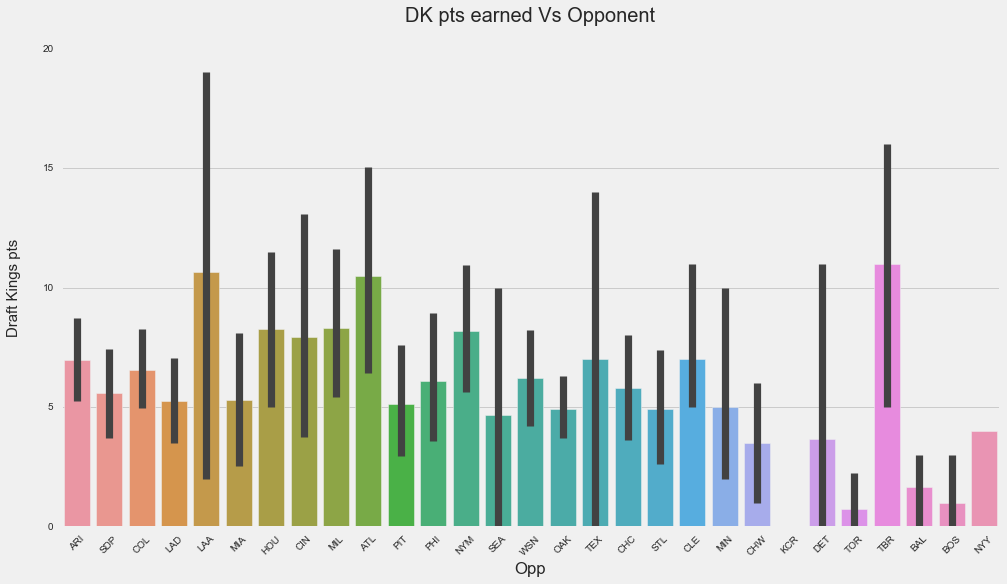

In [50]:
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
# ax = sns.factorplot(x='Opp', y='RE24_bat', kind='box', data=bat_pit_joined)
ax = sns.barplot(x="Opp", y='DK', data=bat_pit_joined)
ax.set_ylabel('Draft Kings pts\n', fontsize=15)
ax.set_title('DK pts earned Vs Opponent\n', fontsize=20)
loc, labels=plt.xticks()
plt.setp(labels,rotation=45)
plt.show()


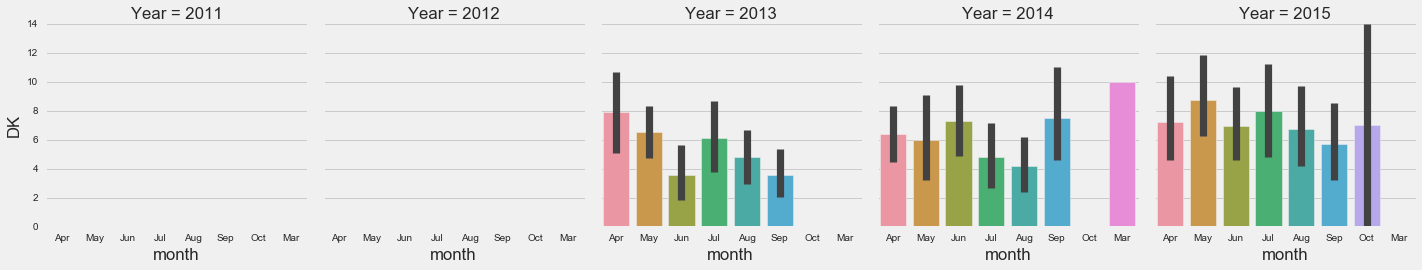

In [51]:
ax = sns.factorplot(x='month', y='DK', col="Year", kind='bar', data=bat_pit_joined)
#Is it plotting the average per month?

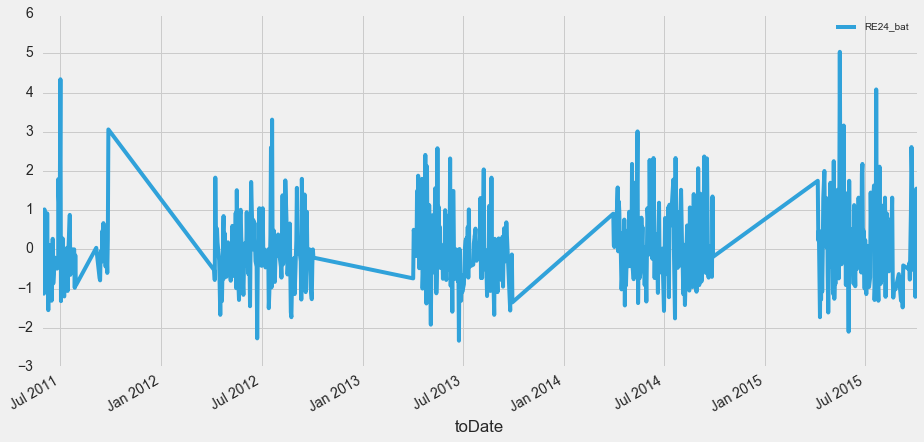

In [10]:

bat_pit_joined[['RE24_bat']].plot(figsize=(14,7), fontsize=14)

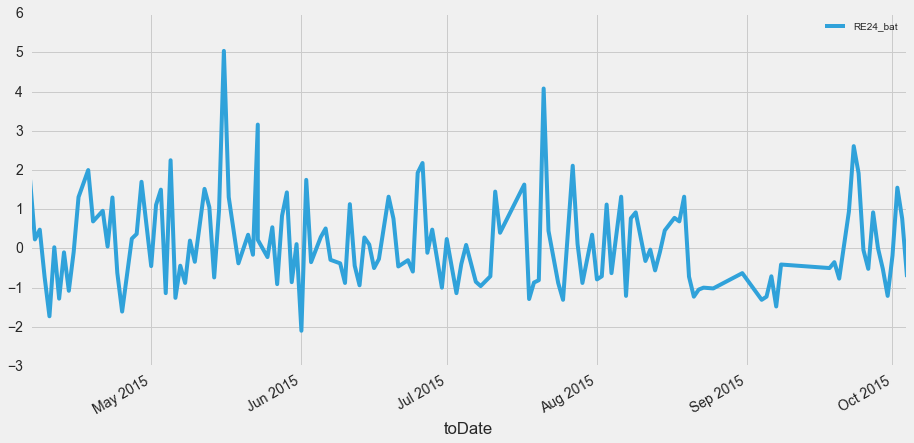

In [11]:
# Filter to one year
Year_2015 = bat_pit_joined[(bat_pit_joined.Year == "2015")]
Year_2015[["RE24_bat"]].plot(figsize=(14,7), fontsize=14)

## Calculate and plot the Rolling Mean for RE24

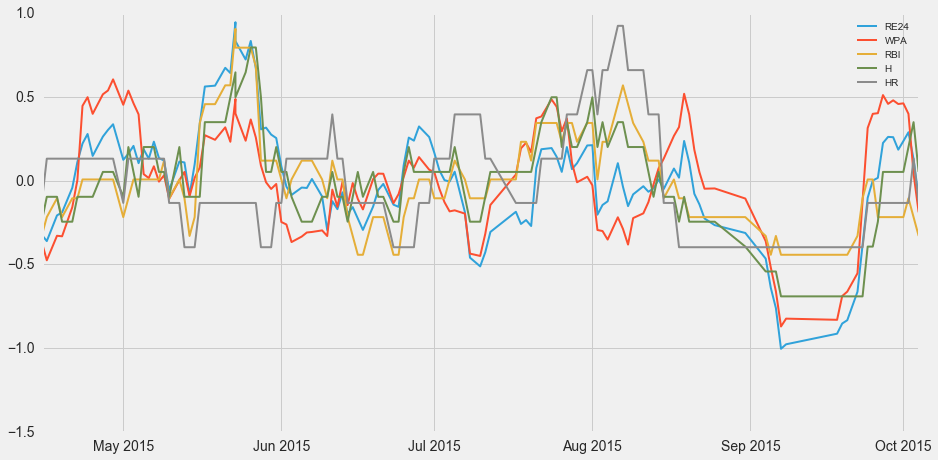

In [41]:
date_ticks1 = Year_2015.index.to_pydatetime()
RE24_2015 = Year_2015['RE24_bat']
RE24_2015 = (RE24_2015 - RE24_2015.mean()) / RE24_2015.std()
RE24_2015_rollmean = RE24_2015.rolling(window=10).mean()

WPA_2015 = Year_2015['WPA_bat']
WPA_2015 = (WPA_2015 - WPA_2015.mean()) / WPA_2015.std()
WPA_2015_rollmean = WPA_2015.rolling(window=10).mean()

RBI_2015 = Year_2015['RBI']
RBI_2015 = (RBI_2015 - RBI_2015.mean()) / RBI_2015.std()
RBI_2015_rollmean = RBI_2015.rolling(window=10).mean()

H_Bat_2015 = Year_2015['H_bat']
H_Bat_2015 = (H_Bat_2015 - H_Bat_2015.mean()) / H_Bat_2015.std()
H_Bat_2015_rollmean = R_Bat_2015.rolling(window=10).mean()

HR_bat_2015 = Year_2015['HR_bat']
HR_bat_2015 = (HR_bat_2015 - HR_bat_2015.mean()) / HR_bat_2015.std()
HR_bat_2015_rollmean = HR_bat_2015.rolling(window=10).mean()

plt.figure(figsize=(14,7))
plt.plot(date_ticks1, RE24_2015_rollmean, alpha=1, lw=2, label="RE24")
plt.plot(date_ticks1, WPA_2015_rollmean, alpha=1, lw=2, label="WPA")
plt.plot(date_ticks1, RBI_2015_rollmean, alpha=1, lw=2, label="RBI")
plt.plot(date_ticks1, R_Bat_2015_rollmean, alpha=1, lw=2, label="H")
plt.plot(date_ticks1, HR_bat_2015_rollmean, alpha=1, lw=2, label="HR")

plt.legend(loc='upper right')

plt.tick_params(labelsize=14)

## Create a Summary DataFrame with rolling means

In [42]:
daily_features = {
    "RE24":[],
    "WPA":[],
    "RBI":[],
    "HR":[],
    "H":[]
} 
df = pd.DataFrame(daily_features)
df.HR = HR_bat_2015_rollmean
df.RBI = RBI_2015_rollmean
df.H = H_Bat_2015_rollmean
df.WPA = WPA_2015_rollmean
df.RE24 = RE24_2015_rollmean
df.iloc[-1,:]

H       0.053125
HR     -0.132311
RBI    -0.329516
RE24   -0.100118
WPA    -0.188221
Name: 2015-10-04 00:00:00, dtype: float64

## Establish my features and target variable

In [48]:
y, X = patsy.dmatrices('DK ~ RE24_bat+WPA_bat+H_bat+HR_bat+RBI', data=bat_pit_joined, return_type="dataframe")
y = np.ravel(y)
X.shape

(425, 6)

## Create my Random Forest for prediction

In [14]:
rfr_best = RandomForestRegressor(max_depth=5, max_leaf_nodes=7, min_samples_split=4, n_estimators=150, random_state=1, n_jobs=1)
rfr_best.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=7, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [15]:
# # set a threshold for which features to include
# X_important = rfr_best.transform(X_train, threshold=0.07)
# X_important.shape

In [16]:
# check the RMSE for a Random Forest that only includes important features
scores = cross_val_score(rfr_best, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

2.6036610111971443

In [49]:
#Now use the rolling average for my features (RE24, WPA, H, HR and RBI) to come up with a prediction of Draft Kings points
#1.- Like you did in the graph above, create a table that contains the rolling averages for these five features
#2.- Use the columns of these new data frame to cross-val predict y
#3.- Ask Sinan if this is how it's done
daily_X = [1, df.RE24[-1], df.WPA[-1], df.H[-1], df.HR[-1],df.RBI[-1]]
todays_pred = rfr_best.predict(daily_X)
todays_pred

/Users/carlosbeas/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 1.09290569])

In [120]:
def get_log_data(gamelogs_url, year):
    
    #url = 'http://www.baseball-reference.com/players/gl.cgi?id=crawfbr01&t=b&year=2015'
    url = gamelogs_url
    #print url
    r = requests.get(url)
    #    print "got to site"
    b = BeautifulSoup(r.text, 'html.parser')
    HTML = r.text 

    #Initialize row identifier
    RK = 1
    end_of_table = False
    
    print gamelogs_url
    
    headers = [''.join(td.xpath('.//text()').extract()) for td in Selector(text=HTML).xpath('//div[3]/table/thead/tr/th')]
    
    #print len(headers)
    
    if len(headers) == 50:
        #It's a pitcher!
        log_data = pd.DataFrame(columns=headers)
        #print log_data.columns
        
    else:

        #Declare a new instance of a Dataframe log
        log_data = pd.DataFrame(columns=(
            'RK', 'Gcar', 'Gtm', 'Date', 'Tm', 'HoA', 'Opp', 'Rslt',
           'Inngs', 'PA', 'AB', 'R', 'H', 'Doubles', 'Tripples', 'HR',
           'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'ROE', 'GDP',
           'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'BOP', 'aLI', 'WPA',
           'RE24', 'DK', 'FD', 'Pos')
        )
    
    exception_cases = []

    #While RK is not null (i.e at the end of the table...)
    #increment RK and collect pitching totals
    while(end_of_table == False):

        #//div[3]/table/tbody/tr[1]/td
        #Gate Keeping code to determine if while loop should proceed
        try: 
            fields = [''.join(td.xpath('.//text()').extract()) for td in Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK)+']/td')]
            #fields = Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK)+']/td/text()').extract()
            ahrefs = Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK)+']/td/a').extract()
            row_number = fields[0].encode('utf-8').strip()
            #print len(fields)
            
        except:
            try:
                #Is this because we have encoutered a "title" row? As opposed to end of table?
                fields = [''.join(td.xpath('.//text()').extract()) for td in Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK+1)+']/td')]
                #fields = Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK+1)+']/td/text()').extract()
                ahrefs = Selector(text=HTML).xpath('//div[3]/table/tbody/tr['+str(RK+1)+']/td/a').extract()
                row_number = fields[0].encode('utf-8').strip()

                RK += 1
            except:
                #We have reached the end of the table
                end_of_table = True
                #print year, RK, len(fields)
                

                
        #print year, row_number, len(fields), len(ahrefs)
        if len(fields) == 38:     #Table has DK, and FD information
            log_data.loc[row_number, "Year"] = year
            log_data.loc[row_number, "ptype"] = "batter"
            log_data.loc[row_number, "RK"] = row_number
            log_data.loc[row_number, "Gcar"] = fields[1].encode('utf-8').strip()
            log_data.loc[row_number, "Gtm"] = fields[2].encode('utf-8').strip()
            log_data.loc[row_number, "Date"] = fields[3].encode('utf-8').strip()
            log_data.loc[row_number, "Tm"] = fields[4].encode('utf-8').strip()
            log_data.loc[row_number, "HoA"] = fields[5].encode('utf-8').strip()
            log_data.loc[row_number, "Opp"] = fields[6].encode('utf-8').strip()
            log_data.loc[row_number, "Rsit"] = fields[7].encode('utf-8').strip()
            log_data.loc[row_number, "Inngs"] = fields[8].encode('utf-8').strip()
            log_data.loc[row_number, "PA"] = fields[9].encode('utf-8').strip()
            log_data.loc[row_number, "AB"] = fields[10].encode('utf-8').strip()
            log_data.loc[row_number, "R"] = fields[11].encode('utf-8').strip()
            log_data.loc[row_number, "H"] = fields[12].encode('utf-8').strip()
            log_data.loc[row_number, "Doubles"] = fields[13].encode('utf-8').strip()
            log_data.loc[row_number, "Tripples"] = fields[14].encode('utf-8').strip()
            log_data.loc[row_number, "HR"] = fields[15].encode('utf-8').strip()
            log_data.loc[row_number, "RBI"] = fields[16].encode('utf-8').strip()
            log_data.loc[row_number, "BB"] = fields[17].encode('utf-8').strip()
            log_data.loc[row_number, "IBB"] = fields[18].encode('utf-8').strip()
            log_data.loc[row_number, "SO"] = fields[19].encode('utf-8').strip()
            log_data.loc[row_number, "HBP"] = fields[20].encode('utf-8').strip()
            log_data.loc[row_number, "SH"] = fields[21].encode('utf-8').strip()
            log_data.loc[row_number, "SF"] = fields[22].encode('utf-8').strip()
            log_data.loc[row_number, "ROE"] = fields[23].encode('utf-8').strip()
            log_data.loc[row_number, "GDP"] = fields[24].encode('utf-8').strip()
            log_data.loc[row_number, "SB"] = fields[25].encode('utf-8').strip()
            log_data.loc[row_number, "CS"] = fields[26].encode('utf-8').strip()
            log_data.loc[row_number, "BA"] = fields[27].encode('utf-8').strip()
            log_data.loc[row_number, "OBP"] = fields[28].encode('utf-8').strip()
            log_data.loc[row_number, "SLG"] = fields[29].encode('utf-8').strip()
            log_data.loc[row_number, "OPS"] = fields[30].encode('utf-8').strip()
            log_data.loc[row_number, "BOP"] = fields[31].encode('utf-8').strip()
            log_data.loc[row_number, "aLI"] = fields[32].encode('utf-8').strip()
            log_data.loc[row_number, "WPA"] = fields[33].encode('utf-8').strip()
            log_data.loc[row_number, "RE24"] = fields[34].encode('utf-8').strip()
            log_data.loc[row_number, "DK"] = fields[35].encode('utf-8').strip()
            log_data.loc[row_number, "FD"] = fields[36].encode('utf-8').strip()
            log_data.loc[row_number, "Pos"] = fields[37].encode('utf-8').strip()
            
        elif len(fields) == 36:
            log_data.loc[row_number, "Year"] = year
            log_data.loc[row_number, "ptype"] = "batter"
            log_data.loc[row_number, "RK"] = row_number
            log_data.loc[row_number, "Gcar"] = fields[1].encode('utf-8').strip()
            log_data.loc[row_number, "Gtm"] = fields[2].encode('utf-8').strip()
            log_data.loc[row_number, "Date"] = fields[3].encode('utf-8').strip()
            log_data.loc[row_number, "Tm"] = fields[4].encode('utf-8').strip()
            log_data.loc[row_number, "HoA"] = fields[5].encode('utf-8').strip()
            log_data.loc[row_number, "Opp"] = fields[6].encode('utf-8').strip()
            log_data.loc[row_number, "Rsit"] = fields[7].encode('utf-8').strip()
            log_data.loc[row_number, "Inngs"] = fields[8].encode('utf-8').strip()
            log_data.loc[row_number, "PA"] = fields[9].encode('utf-8').strip()
            log_data.loc[row_number, "AB"] = fields[10].encode('utf-8').strip()
            log_data.loc[row_number, "R"] = fields[11].encode('utf-8').strip()
            log_data.loc[row_number, "H"] = fields[12].encode('utf-8').strip()
            log_data.loc[row_number, "Doubles"] = fields[13].encode('utf-8').strip()
            log_data.loc[row_number, "Tripples"] = fields[14].encode('utf-8').strip()
            log_data.loc[row_number, "HR"] = fields[15].encode('utf-8').strip()
            log_data.loc[row_number, "RBI"] = fields[16].encode('utf-8').strip()
            log_data.loc[row_number, "BB"] = fields[17].encode('utf-8').strip()
            log_data.loc[row_number, "IBB"] = fields[18].encode('utf-8').strip()
            log_data.loc[row_number, "SO"] = fields[19].encode('utf-8').strip()
            log_data.loc[row_number, "HBP"] = fields[20].encode('utf-8').strip()
            log_data.loc[row_number, "SH"] = fields[21].encode('utf-8').strip()
            log_data.loc[row_number, "SF"] = fields[22].encode('utf-8').strip()
            log_data.loc[row_number, "ROE"] = fields[23].encode('utf-8').strip()
            log_data.loc[row_number, "GDP"] = fields[24].encode('utf-8').strip()
            log_data.loc[row_number, "SB"] = fields[25].encode('utf-8').strip()
            log_data.loc[row_number, "CS"] = fields[26].encode('utf-8').strip()
            log_data.loc[row_number, "BA"] = fields[27].encode('utf-8').strip()
            log_data.loc[row_number, "OBP"] = fields[28].encode('utf-8').strip()
            log_data.loc[row_number, "SLG"] = fields[29].encode('utf-8').strip()
            log_data.loc[row_number, "OPS"] = fields[30].encode('utf-8').strip()
            log_data.loc[row_number, "BOP"] = fields[31].encode('utf-8').strip()
            log_data.loc[row_number, "aLI"] = fields[32].encode('utf-8').strip()
            log_data.loc[row_number, "WPA"] = fields[33].encode('utf-8').strip()
            log_data.loc[row_number, "RE24"] = fields[34].encode('utf-8').strip()
            log_data.loc[row_number, "DK"] = ""
            log_data.loc[row_number, "FD"] = ""
            log_data.loc[row_number, "Pos"] = fields[35].encode('utf-8').strip()
        
        elif len(fields) == 50:
            
            log_data.loc[row_number, "Year"] = year
            log_data.loc[row_number, "ptype"] = "pitcher"
            log_data.loc[row_number, "Rk"] = row_number
            
            for i in np.arange(1, len(fields), 1):
                    
                    h = headers[i].encode('utf-8').strip()
                    log_data.loc[row_number, h] = fields[i].encode('utf-8').strip()
            
        else:
            exception_cases.append(RK)
            
        
        RK += 1

#         if RK > 3:
#             end_of_table = True
    
    return log_data

#get_log_data("http://www.baseball-reference.com/players/gl.cgi?id=abadfe01&t=p&year=2016", 2016)

In [132]:
#Build a function that calculates the rolling mean for the features I need to make my predictiom
# 1.- scrape the values for last ten games
# 2.- calculate rolling mean
# 3.- return the result

plt.style.use('fivethirtyeight')
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import datetime as dt

def turn_to_float(val):
    #print val
    fl = float(val)
    return fl

def turn_to_int(val):
    #print val
    try:
        i = int(val)
    except:
        return val
    return i

def calculate_rolling_means(glog):
    rol_means = pd.DataFrame()
    
    if glog.ptype[0] == "batter":
        
        #Ensure values of interest in dataframe are numeric
        #Since feature extraction analysis has not been run 
        #for pitcher, defaulting to two common features that are equally as important for pitcher
        glog.WPA = glog.WPA.map(turn_to_float)
        glog.RE24 = glog.RE24.map(turn_to_float)
        glog.RBI = glog.RBI.map(turn_to_float)
        glog.H = glog.H.map(turn_to_float)
        glog.HR = glog.HR.map(turn_to_float)
        
        #Calculate rolling mean for batter features
        RE24 = glog['RE24']
        RE24 = (RE24 - RE24.mean()) / RE24.std()
        RE24_rollmean = RE24.rolling(window=10).mean()
        rol_means["RE24"] = RE24_rollmean

        WPA = glog['WPA']
        WPA = (WPA - WPA.mean()) / WPA.std()
        WPA_rollmean = WPA.rolling(window=10).mean()
        rol_means["WPA"] = WPA_rollmean

        RBI = glog['RBI']
        RBI = (RBI - RBI.mean()) / RBI.std()
        RBI_rollmean = RBI.rolling(window=10).mean()
        rol_means["RBI"] = RBI_rollmean

        H = glog['H']
        H = (H - H.mean()) / H.std()
        H_rollmean = H.rolling(window=10).mean()
        rol_means["H"] = H_rollmean

        HR = glog['HR']
        HR = (HR - HR.mean()) / HR.std()
        HR_rollmean = HR.rolling(window=10).mean()
        rol_means["HR"] = HR_rollmean
    
    if glog.ptype[0] == "pitcher":
        
        #Ensure values of interest in dataframe are numeric
        #Since feature extraction analysis has not been run 
        #for pitcher, defaulting to two common features that are equally as important for pitcher
        glog.WPA = glog.WPA.map(turn_to_float)
        glog.RE24 = glog.RE24.map(turn_to_float)
        #Calculate rolling mean for pitcher features
        
        RE24 = glog['RE24']
        RE24 = (RE24 - RE24.mean()) / RE24.std()
        RE24_rollmean = RE24.rolling(window=10).mean()
        rol_means["RE24"] = RE24_rollmean

        WPA = glog['WPA']
        WPA = (WPA - WPA.mean()) / WPA.std()
        WPA_rollmean = WPA.rolling(window=10).mean()
        rol_means["WPA"] = WPA_rollmean

    
    return rol_means

def get_rolling_mean(player):
    
    today = dt.datetime.today().strftime("%m/%d/%Y")
    today = today.split("/")
    this_month = today[0]
    this_day = today[1]
    this_year = today[2]
    
    
    #Load the player dictionary table containing player URL extensions
    player_index = pd.read_csv("/Users/carlosbeas/sfdat26-beas/Capstone/Capstone_MLB/Data/player_index.csv")
    row_of_interest = (player_index.name == player)
    if len(row_of_interest) == 0:
        #Player was not found
        print "Error:  Player does not exist"
        empty_df = pd.DataFrame()
        return empty_df
    else:
        #Follow the URL extension found in the "links" field of the data frame
        #print player_index[row_of_interest].links
        index_of_interest = player_index[row_of_interest].index
        #print index_of_interest[0]
        extension = player_index.iloc[index_of_interest[0]]["links"]
        extension = str(extension)
        #print extension
        player_url = "http://www.baseball-reference.com"+extension
        print player_url
        #Follow the URL and extract the additional data needed
        r = requests.get(player_url)
        #    print "got to site"
        b = BeautifulSoup(r.text, 'html.parser')
        HTML = r.text
        
        #xpath for Gamelogs:  //div[2]/div[4]/ul/li/a
        try:
            fields = Selector(text=HTML).xpath('//div[2]/div[4]/ul/li/a').extract()
            gamelogs_url = fields[2].encode('utf-8').strip()

        except:
            #fields = Selector(text=HTML).xpath('//div[5]/div[2]/div[2]/ul/li/a')
            gamelogs_url = re.search('<a href="(\/players\/gl.*)">Game Logs', HTML).group(1)
            print gamelogs_url
            
        url = "http://www.baseball-reference.com"+gamelogs_url + str(this_year)
        
        #print url
        try:

            game_log = get_log_data(url, this_year)

        except:
            #We have found a year log that does not exist for this player and it is likely that the preceeding years
            #also do not exist...
            print "ERROR:  This is not an active player."
            empty_df = pd.DataFrame()
            return empty_df
        
        #print game_log.shape
        
        my_rolling_mean = pd.DataFrame()
        months = []
        days = []
        #game_log["toDate"] = 
    
        #gameday = game_log.Date.map(lambda x: x.split())
        for i in np.arange(0, game_log.shape[0], 1):
            gameday = game_log.Date[i]
            gameday = str(gameday)
            month = re.search('(\w+)', gameday).group(1)
            #print month
            day = re.search('(\d+)', gameday).group(1)
            #print day
            months.append(month)
            days.append(day)
    #       print day
            
        #print months
        game_log["toDate"] = game_log["Year"] + "-" + months + "-" + days
        #print game_log["toDate"]
        game_log.toDate = pd.to_datetime(game_log.toDate)
        game_log.set_index('toDate', inplace=True)
        
        #get rolling mean of features for player
        my_rolling_mean = calculate_rolling_means(game_log)
        my_rolling_mean = my_rolling_mean.iloc[-1]
        
    return my_rolling_mean

#Get rolling mean of features for a pitcher
r = get_rolling_mean("Fernando Abad")
r = pd.DataFrame(r)
r.T

http://www.baseball-reference.com/players/a/abadfe01.shtml
/players/gl.cgi?id=abadfe01&amp;t=p&amp;year=
http://www.baseball-reference.com/players/gl.cgi?id=abadfe01&amp;t=p&amp;year=2016
(57, 52)


,RE24,WPA
2016-09-25,-0.048934,-0.110468


In [133]:
#Get rolling mean of features for a batter
r = get_rolling_mean("Brandon Crawford")
r = pd.DataFrame(r)
r.T

http://www.baseball-reference.com/players/c/crawfbr01.shtml
/players/gl.cgi?id=crawfbr01&amp;t=b&amp;year=
http://www.baseball-reference.com/players/gl.cgi?id=crawfbr01&amp;t=b&amp;year=2016
(155, 41)


,RE24,WPA,RBI,H,HR
2016-10-02,0.299603,0.139289,-0.142642,0.410211,-0.288747
